In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Load mpg dataset and prepare for classification

In [3]:
df = sns.load_dataset('mpg')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [4]:
df['origin_simple'] = df.origin.map({'europe' : 'non-usa', 'japan' : 'non-usa', 'usa':'usa'})

# Data Understanding: Features and Target Visualization
We use only mpg and weight as features in the beginning.

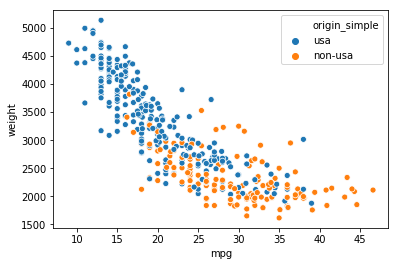

In [5]:
sns.scatterplot(data=df, x='mpg', y='weight', hue='origin_simple'); plt.show()

# Preparation
## Remove Null-Values

In [6]:
df = df.dropna()

# Naive Bayes Approach

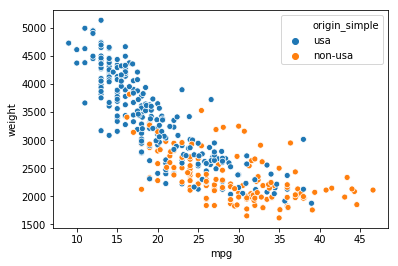

In [7]:
dfb = df[['mpg', 'weight', 'origin_simple']].copy()#.sample(20, random_state=5)
sns.scatterplot(data=dfb, x='mpg', y='weight', hue='origin_simple'); plt.show()

## Preparation of a simplified dataframe
We bin the data of weight and mpg.

In [8]:
dfb['weight_b'] = pd.cut(dfb.weight, bins=3, labels=['light', 'moderate', 'heavy'])
dfb['mpg_b'] = pd.cut(dfb.mpg, bins=2, labels=['short-range', 'long-range'])
dfb.head(20)

,mpg,weight,origin_simple,weight_b,mpg_b
0,18.0,3504,usa,moderate,short-range
1,15.0,3693,usa,moderate,short-range
2,18.0,3436,usa,moderate,short-range
3,16.0,3433,usa,moderate,short-range
4,17.0,3449,usa,moderate,short-range
5,15.0,4341,usa,heavy,short-range
6,14.0,4354,usa,heavy,short-range
7,14.0,4312,usa,heavy,short-range
8,14.0,4425,usa,heavy,short-range
9,15.0,3850,usa,moderate,short-range


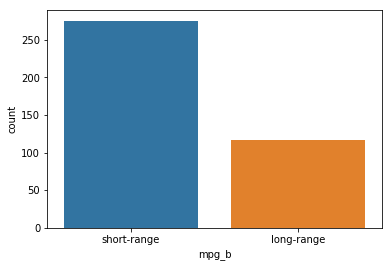

,mpg,weight,origin_simple,weight_b
mpg_b,,,,
short-range,275,275,275,275
long-range,117,117,117,117


In [9]:
sns.countplot(dfb['mpg_b']);plt.show()
dfb.groupby('mpg_b').count()

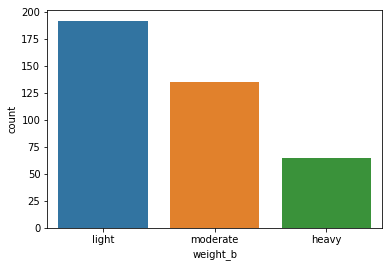

,mpg,weight,origin_simple,mpg_b
weight_b,,,,
light,192,192,192,192
moderate,135,135,135,135
heavy,65,65,65,65


In [10]:
sns.countplot(dfb['weight_b']);plt.show()
dfb.groupby('weight_b').count()

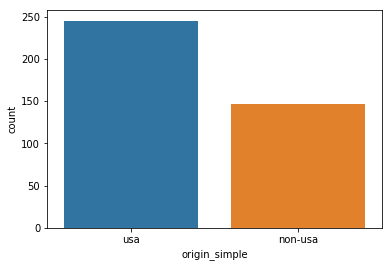

,mpg,weight,weight_b,mpg_b
origin_simple,,,,
non-usa,147,147,147,147
usa,245,245,245,245


In [11]:
sns.countplot(dfb['origin_simple']);plt.show()
dfb.groupby('origin_simple').count()

## Bayes Theorem
We can calculate the probability (i.e. predict) that a car is from the US given it has long-range capability (=feature value) using Bayes Theorem.
### First case: only one feature

In [12]:
gr_mpg = dfb.groupby(['mpg_b', 'origin_simple']).origin_simple.count()
gr_mpg

mpg_b        origin_simple
short-range  non-usa           65
             usa              210
long-range   non-usa           82
             usa               35
Name: origin_simple, dtype: int64

In [13]:
# P(USA | short-range) = P(short-range | USA)*P(USA) / P(short-range)
l_dfb = len(dfb)
p_usa = len(dfb.query('origin_simple=="usa"')) / l_dfb # 245 / 392
p_short_range = len(dfb.query('mpg_b=="short-range"')) / l_dfb  # 275 / 392
p_short_range__usa = gr_mpg['short-range']['usa'] / len(dfb.query('origin_simple=="usa"')) # 210 / 245

In [14]:
p_usa__short_range = p_short_range__usa * p_usa / p_short_range
p_usa__short_range

0.7636363636363636

### Second case: mulitple features

In [15]:
gr_weight = dfb.groupby(['weight_b', 'origin_simple']).origin_simple.count()
gr_weight
gr_weight['heavy']['non-usa'] = 0
gr_weight

weight_b  origin_simple
light     non-usa          123
          usa               69
moderate  non-usa           24
          usa              111
heavy     usa               65
Name: origin_simple, dtype: int64

In [16]:
# P(USA | short-range, heavy) = P(short-range | USA) * P(heavy | USA) * P(USA) / P(short-range) * P(heavy)
#                               ------------------------------------- naive bayes assumption -------------
#                                                                         (conditional independence)
l_dfb = len(dfb)
p_usa = len(dfb.query('origin_simple=="usa"')) / l_dfb # 245 / 392
p_short_range = len(dfb.query('mpg_b=="short-range"')) / l_dfb  # 275 / 392
p_short_range__usa = gr_mpg['short-range']['usa'] / len(dfb.query('origin_simple=="usa"')) # 210 / 245
p_heavy = len(dfb.query('weight_b=="heavy"')) / l_dfb  # 65 / 392
p_heavy__usa = gr_weight['heavy']['usa'] / len(dfb.query('origin_simple=="usa"')) # 65 / 245

In [17]:
p_usa__short_range_and_heavy = p_short_range__usa * p_heavy__usa * p_usa / (p_short_range * p_heavy)
p_usa__short_range_and_heavy

1.2218181818181821

In [18]:
# P(NON-USA | short-range, heavy) = P(short-range | NON-USA) * P(heavy | NON-USA) * P(NON-USA) / P(short-range) * P(heavy)
#                               ------------------------------------- naive bayes assumption -------------
#                                                                         (conditional independence)
l_dfb = len(dfb)
p_non_usa = len(dfb.query('origin_simple=="non-usa"')) / l_dfb 
p_short_range = len(dfb.query('mpg_b=="short-range"')) / l_dfb  # 275 / 392
p_short_range__non_usa = gr_mpg['short-range']['non-usa'] / len(dfb.query('origin_simple=="non-usa"'))
p_heavy = len(dfb.query('weight_b=="heavy"')) / l_dfb  # 65 / 392
p_heavy__non_usa = len(dfb.query('weight_b=="heavy" and origin_simple=="non-usa"')) / len(dfb.query('origin_simple=="non-usa"'))

In [19]:
p_non_usa__short_range_and_heavy = p_short_range__non_usa * p_heavy__non_usa * p_non_usa / (p_short_range * p_heavy)
p_non_usa__short_range_and_heavy

0.0

# Naive Bayes in scikit-learn

In [20]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

X = dfb[['mpg', 'weight']].copy()
y = dfb['origin_simple']

clf.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [21]:
data = [[1,2]]
print(clf.predict_proba(data))
print(clf.predict(data))

[[1.25383044e-05 9.99987462e-01]]
['usa']


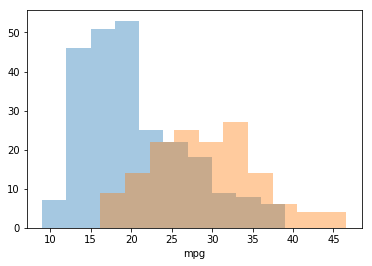

In [22]:
sns.distplot(dfb[dfb.origin_simple=='usa'].mpg, kde=False, bins=10)
sns.distplot(dfb[dfb.origin_simple=='non-usa'].mpg, kde=False, bins=10)
plt.show()

## We can fit a normal distribution to the mpg- and weight-values (for both classes)
Note: we assume independence of both feature variables! This is actually not correct.

In [23]:
from scipy.stats import norm
# Fit a normal distribution to the data:
mu_us, std_us = norm.fit(dfb[dfb.origin_simple=='usa'].mpg)
print("MPG:")
print("mu (us) = {}, std (us) = {}".format(round(mu_us,2), round(std_us,2)))
mu_nus, std_nus = norm.fit(dfb[dfb.origin_simple=='non-usa'].mpg)
print("mu (non-us) = {}, std (non-us) = {}".format(round(mu_nus,2), round(std_nus,2)))

mu_us, std_us = norm.fit(dfb[dfb.origin_simple=='usa'].weight)
print("WEIGHT:")
print("mu (us) = {}, std (us) = {}".format(round(mu_us,2), round(std_us,2)))
mu_nus, std_nus = norm.fit(dfb[dfb.origin_simple=='non-usa'].weight)
print("mu (non-us) = {}, std (non-us) = {}".format(round(mu_nus,2), round(std_nus,2)))

MPG:
mu (us) = 20.03, std (us) = 6.43
mu (non-us) = 29.13, std (non-us) = 6.44
WEIGHT:
mu (us) = 3372.49, std (us) = 793.72
mu (non-us) = 2319.41, std (non-us) = 419.46


C:\Users\peer.kueppers\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


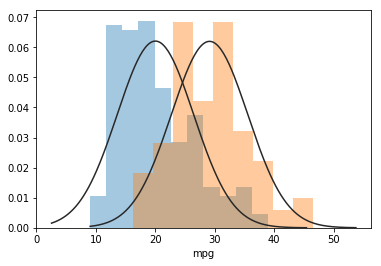

In [24]:
sns.distplot(dfb[dfb.origin_simple=='usa'].mpg, kde=False, fit=norm)
sns.distplot(dfb[dfb.origin_simple=='non-usa'].mpg, kde=False, fit=norm)
plt.show()

C:\Users\peer.kueppers\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


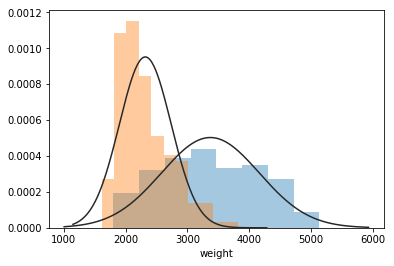

In [25]:
sns.distplot(dfb[dfb.origin_simple=='usa'].weight, kde=False, fit=norm)
sns.distplot(dfb[dfb
                 .origin_simple=='non-usa'].weight, kde=False, fit=norm)
plt.show()

# ML-preparation: Features and Target

In [26]:
#X = df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']]
X = df[['mpg', 'weight']]
y = df['origin_simple']

# Search for Optimal Parameter by Grid Search

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

# define the parameter grid
# the pipeline stage is followed by two underscores "__" and then the parameter to be varied is named (as key)
# the value is a list of parameter values to be searched
param_grid = [
    {'var_smoothing': [1e-09]     # we do not optimize NaiveBayes
    }
]

search = GridSearchCV(clf, param_grid, cv=10)

search.fit(X, y)
print("Best parameter (CV score={:.2f}):{})".format(search.best_score_, search.best_params_))

Best parameter (CV score=0.76):{'var_smoothing': 1e-09})


## Visualize Results of Grid-Search

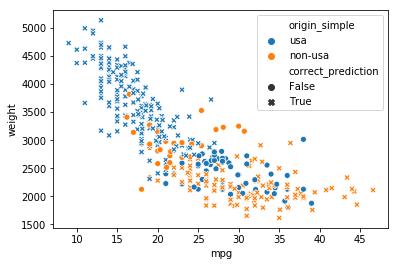

In [28]:
df_viz = pd.DataFrame(X).copy()
df_viz['origin_simple'] = y
df_viz['prediction'] = search.predict(X)
df_viz['correct_prediction'] = (df_viz.origin_simple == df_viz.prediction)
sns.scatterplot(data=df_viz, x='mpg', y='weight', hue='origin_simple', style='correct_prediction'); plt.show()

# Add further features

In [29]:
X_all_features = df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']]
y_all_features = df['origin']

In [30]:
clf = GaussianNB()

search_all_features = GridSearchCV(clf, param_grid, cv=10)
search_all_features.fit(X_all_features, y_all_features)
print("Best parameter (CV score={:.2f}):{})".format(search_all_features.best_score_, search.best_params_))

# why is this worse?

Best parameter (CV score=0.67):{'var_smoothing': 1e-09})


# Visualization of the Decision Boundary

In [31]:
from sklearn.preprocessing import MinMaxScaler  # in order to understand the decision boundary, we'll normalize our data

X = MinMaxScaler().fit_transform(df[['mpg', 'horsepower']])
y = df['origin_simple'].map({'usa':1, 'non-usa':2})  # the visualization below cannot work with nominal values

clf_arr = []  # this array holds the knn-predictors
clf_name_arr = []  # this array holds the names of the knn-predictors for visualization
var_smoothing_arr = [1e-14, 1e-12, 1e-10, 1e-9, 1e-8]
for i in range(len(var_smoothing_arr)):
    clf = GaussianNB(var_smoothing=var_smoothing_arr[i])
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("Naive Bayes (var_smoothing: {})".format(var_smoothing_arr[i]))


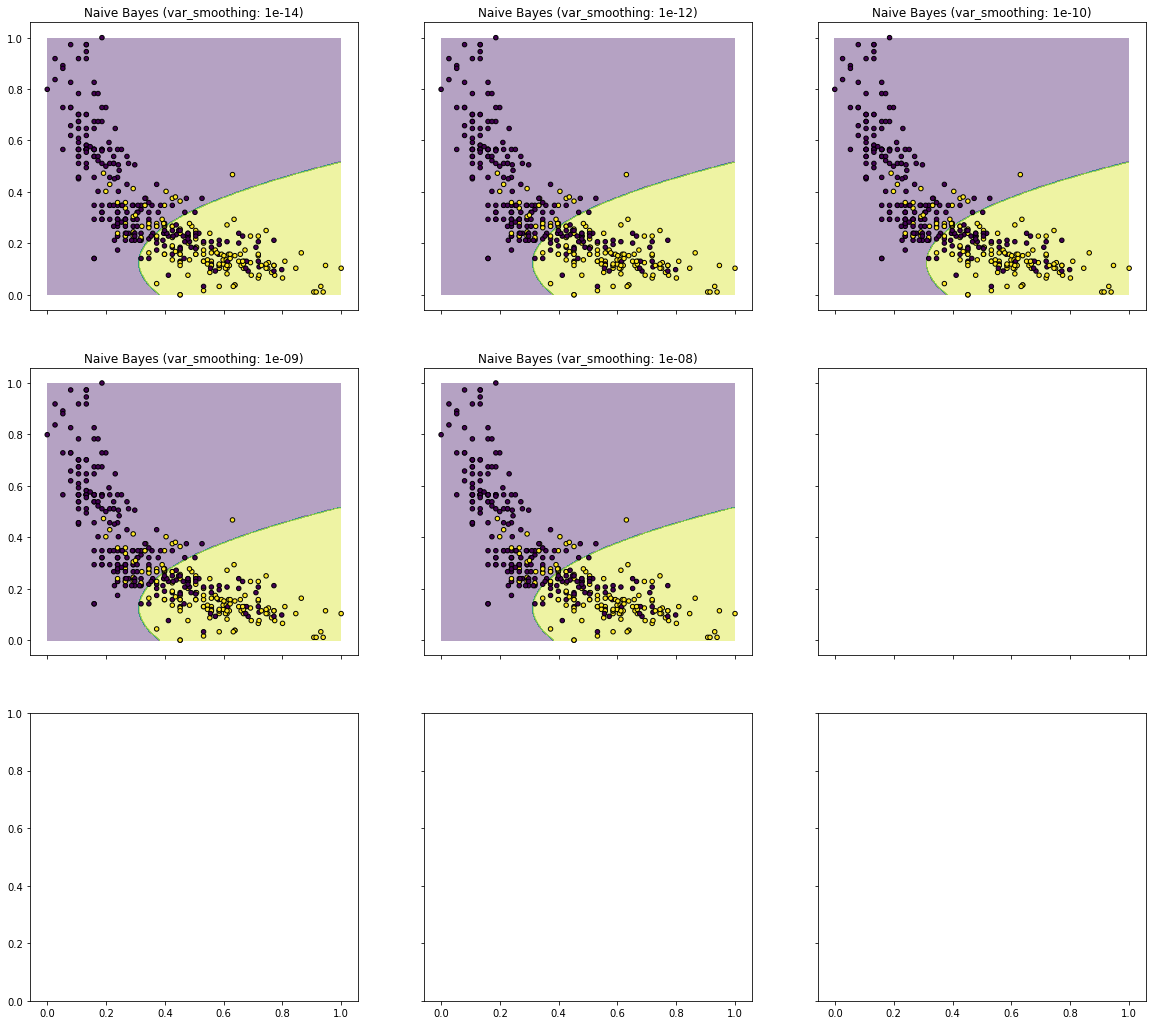

In [32]:
# for the approach, see https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

from itertools import product

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min(), X[:, 0].max()  # this is always 0,1 if MinMaxSclaer is used
y_min, y_max = X[:, 1].min(), X[:, 1].max() # this is always 0,1 if MinMaxSclaer is used
steps = 300  # --> looks better if larger
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/steps),
                     np.arange(y_min, y_max, (y_max-y_min)/steps))  


f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 18))

# for each model, create the decision boundary and plot it into the right sub-plot (via idx)
for idx, clf, tt in zip(product([0,1,2], [0,1,2]), clf_arr, clf_name_arr):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)  # predict the mesh
       
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)  # draw decision boundary
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')  # plot the original data (normalized)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Comparing all classifiers so far in another example

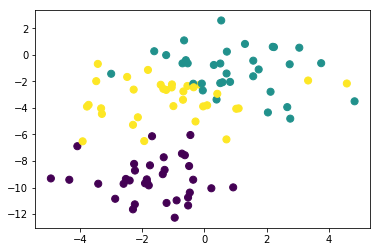

In [33]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=3, random_state=2, cluster_std=1.5)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

clf_arr = []  # this array holds the knn-predictors
clf_name_arr = []  # this array holds the names of the knn-predictors for visualization

clf1 = KNeighborsClassifier(n_neighbors=10)
clf1.fit(X, y)
clf_arr.append(clf1)
clf_name_arr.append("KNN (k=10)")


clf2 = DecisionTreeClassifier(max_depth=10)
clf2.fit(X, y)
clf_arr.append(clf2)
clf_name_arr.append("Decision Tree (max_depth=10)")

clf3 = GaussianNB()
clf3.fit(X, y)
clf_arr.append(clf3)
clf_name_arr.append("Naive Bayes")

clf4 = SVC(gamma='auto', kernel='linear')
clf4.fit(X, y)
clf_arr.append(clf4)
clf_name_arr.append("SVC (linear kernel)")


clf5 = SVC(gamma='auto', kernel='rbf')
clf5.fit(X, y)
clf_arr.append(clf5)
clf_name_arr.append("SVC (rbf kernel)")

clf6 = SVC(gamma='auto', kernel='poly', degree=2)
clf6.fit(X, y)
clf_arr.append(clf6)
clf_name_arr.append("SVC (polynomianl kernel, degree=2)")

clf7 = SVC(gamma='auto', kernel='poly', degree=3)
clf7.fit(X, y)
clf_arr.append(clf7)
clf_name_arr.append("SVC (polynomianl kernel, degree=3)")


clf8 = LogisticRegression()
clf8.fit(X, y)
clf_arr.append(clf8)
clf_name_arr.append("Logistic Regression")

C:\Users\peer.kueppers\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\peer.kueppers\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


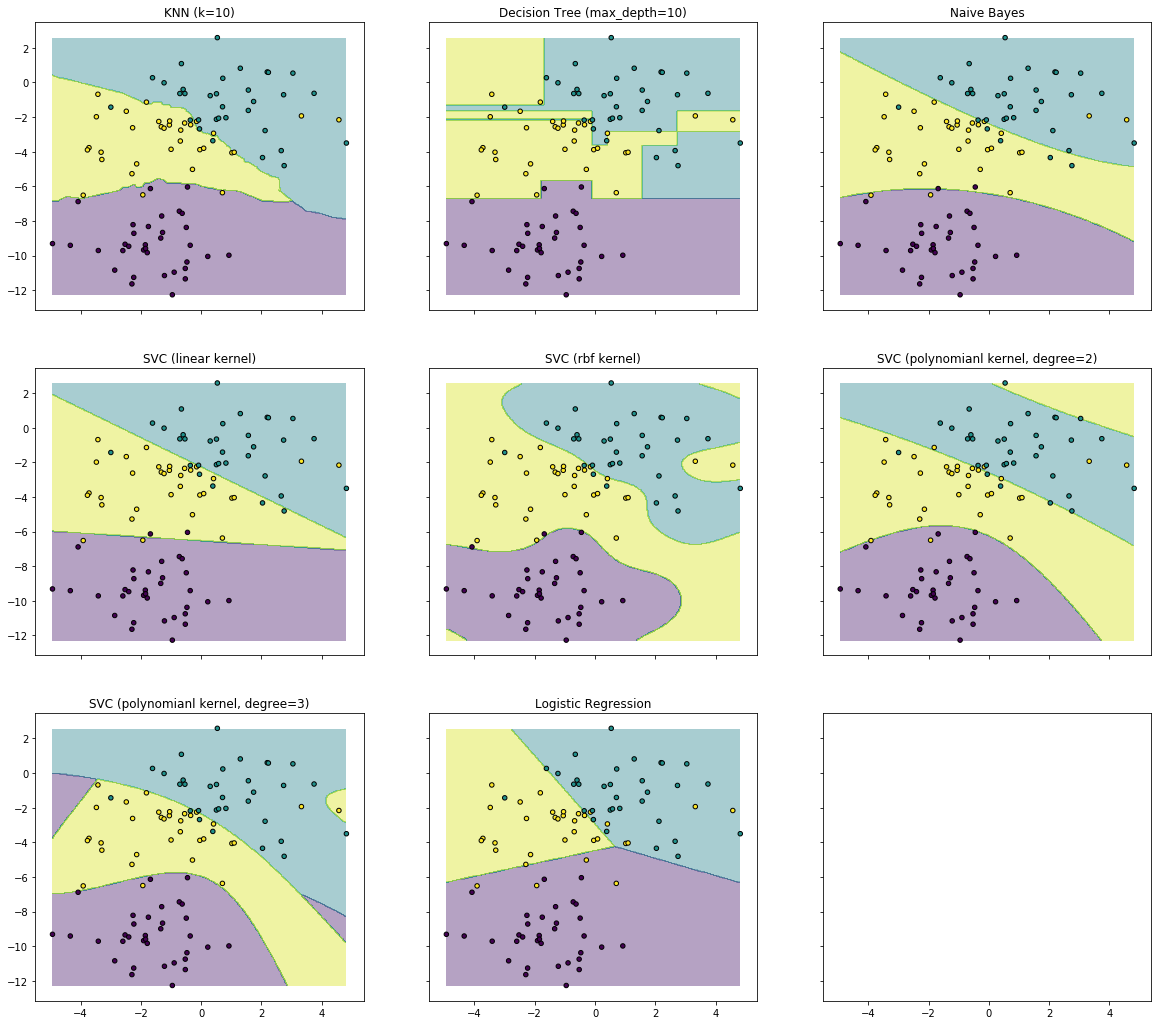

In [35]:

# for the approach, see https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

from itertools import product

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min(), X[:, 0].max()  # this is always 0,1 if MinMaxSclaer is used
y_min, y_max = X[:, 1].min(), X[:, 1].max() # this is always 0,1 if MinMaxSclaer is used
steps = 300  # --> looks better if larger
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/steps),
                     np.arange(y_min, y_max, (y_max-y_min)/steps))  


f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 18))

# for each model, create the decision boundary and plot it into the right sub-plot (via idx)
for idx, clf, tt in zip(product([0,1,2], [0,1,2]), clf_arr, clf_name_arr):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)  # predict the mesh
       
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)  # draw decision boundary
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')  # plot the original data (normalized)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Visualization of the Naive Bayes Model with Gaussian Assumption
In a simple model we assume that the data is described by a Gaussian distribution with <b>no covariance between features</b>. In the model-fit the mean and standard deviation of the samples of each class are calculated. The result of this naive Gaussian assumption is shown below.

[(-15, 5), (-8, 8)]

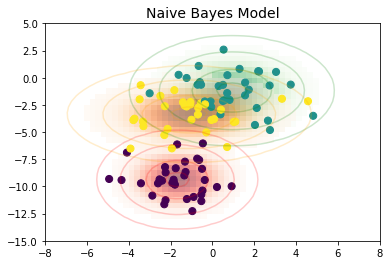

In [44]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'green', 'orange']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

# see https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html